In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [90]:
from sklearn.datasets import make_moons, make_blobs

# 1️⃣ Create non-spherical clusters
moons, _ = make_moons(n_samples=400, noise=0.08, random_state=42)
blobs, _ = make_blobs(n_samples=100, centers=[(2.5, 2.5)], cluster_std=0.3, random_state=42)

# 2️⃣ Combine them into one dataset
X = np.vstack([moons, blobs])

# 3️⃣ Normalize features
X = StandardScaler().fit_transform(X)

# 4️⃣ Convert to pandas DataFrame
df = pd.DataFrame(X, columns=['feature_1', 'feature_2'])

In [92]:
df.shape

(500, 2)

In [94]:
df.head()

,feature_1,feature_2
0,-0.838120,-0.279308
1,-0.185208,-1.097727
2,-0.056819,-0.168924
3,-0.677444,-0.413962
4,-0.723893,0.247234


#### Visualize data distribution

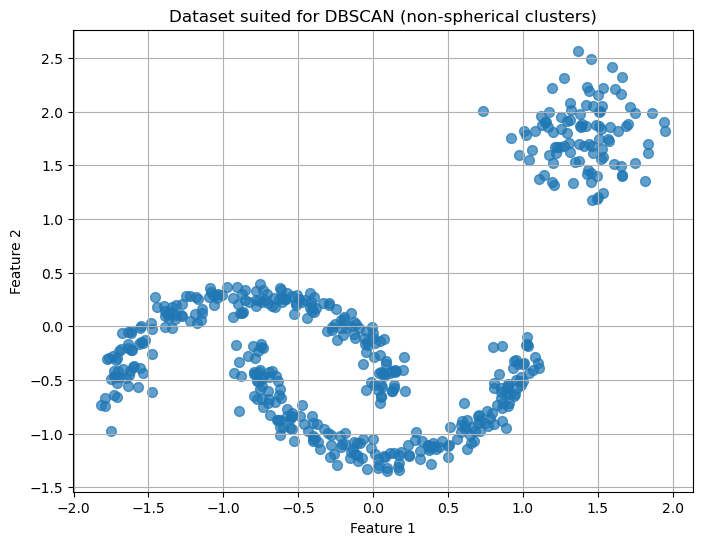

In [97]:
# 5️⃣ Visualize before clustering
plt.figure(figsize=(8, 6))
plt.scatter(df['feature_1'], df['feature_2'], s=50, alpha=0.7)
plt.title("Dataset suited for DBSCAN (non-spherical clusters)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()

## 1. DBSCAN

#### K-distance plot to find optimal value of eps.

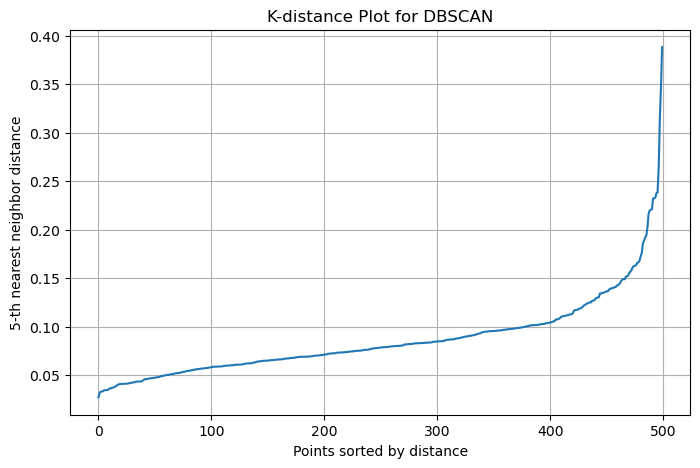

In [101]:
from sklearn.neighbors import NearestNeighbors

X = df[['feature_1', 'feature_2']].values

# Compute the distance to the k-th nearest neighbor
k = 5  # typically equal to min_samples
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Take the k-th nearest neighbor distance
k_distances = np.sort(distances[:, k-1])

# Plot k-distance graph
plt.figure(figsize=(8, 5))
plt.plot(k_distances)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{k}-th nearest neighbor distance")
plt.title("K-distance Plot for DBSCAN")
plt.grid(True)
plt.show()

The point where the curve bends sharply (the “elbow”) is a good estimate for eps. Points with distance larger than this are likely to be noise.

From the graph, we can see that the is a sharp bend of the curve between 0.15 and 0.25. So taking any value between as eps.

#### Train the model

In [116]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=5) ## Default values
dbscan.fit(df)

# Add cluster labels to DataFrame
temp = df.copy()
temp['cluster'] = dbscan.labels_

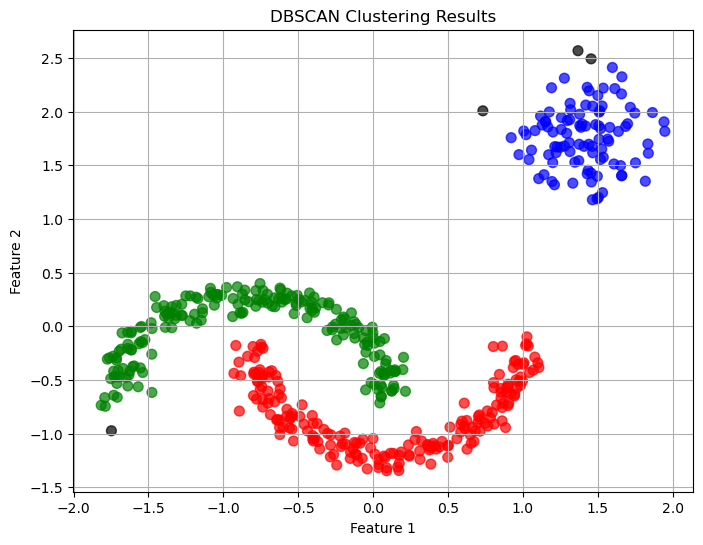

In [118]:
# Define colors (black for noise)
colors = ['red', 'green', 'blue', 'purple', 'orange']
cluster_colors = ['black' if label == -1 else colors[label % len(colors)] for label in temp['cluster']]

# Plot results
plt.figure(figsize=(8, 6))
plt.scatter(temp['feature_1'], temp['feature_2'], c=cluster_colors, s=50, alpha=0.7)
plt.title("DBSCAN Clustering Results")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()

## 2. K-Means

#### Elbow method to find the value of K:

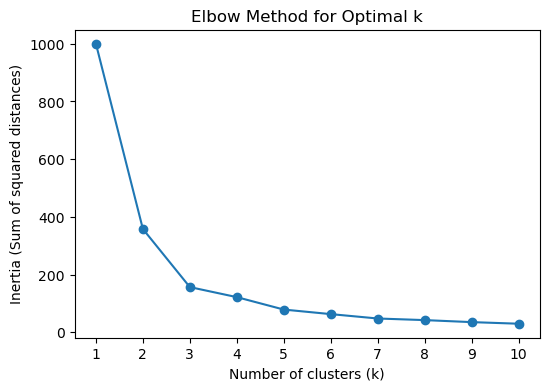

In [122]:
from sklearn.cluster import KMeans
# Try different values of k
inertia = []
K_range = range(1, 11)  # Check k from 1 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df[['feature_1', 'feature_2']])
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(6,4))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Sum of squared distances)')
plt.title('Elbow Method for Optimal k')
plt.xticks(range(1, 11)) 
plt.show()


#### Using Kneed method to find exact value of K

In [125]:
from kneed import KneeLocator

# Suppose K_range and wcss are already defined
knee = KneeLocator(K_range, inertia, curve='convex', direction='decreasing')
optimal_k = knee.knee
print("Optimal number of clusters:", optimal_k)


Optimal number of clusters: 3


#### Train the model

In [134]:
# Set the number of clusters
k = 3  

# Initialize KMeans
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)

# Fit the model to the data
kmeans.fit(df[['feature_1', 'feature_2']])

# Assign cluster labels to each point
temp2 = df.copy()
temp2['cluster'] = kmeans.labels_

# Check the first few rows
temp2.head()

,feature_1,feature_2,cluster
0,-0.838120,-0.279308,0
1,-0.185208,-1.097727,2
2,-0.056819,-0.168924,2
3,-0.677444,-0.413962,0
4,-0.723893,0.247234,0


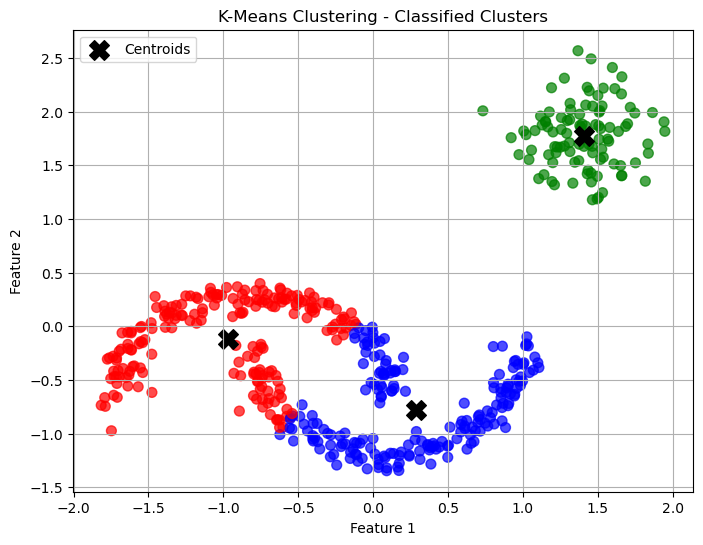

In [136]:
import matplotlib.pyplot as plt

# Assuming kmeans is already trained
colors = ['red', 'green', 'blue']  # cluster colors in your desired order

# Map cluster labels to colors
cluster_colors = [colors[label] for label in kmeans.labels_]

plt.figure(figsize=(8, 6))
plt.scatter(temp2['feature_1'], temp2['feature_2'], c=cluster_colors, s=50, alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            c='black', s=200, marker='X', label='Centroids')
plt.title("K-Means Clustering - Classified Clusters")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()
